In [37]:
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

## Loading data

In [2]:
df = load_wine(return_X_y=False, as_frame=True)['frame'].sample(frac = 1)

### Adding incorrect train and test splitting

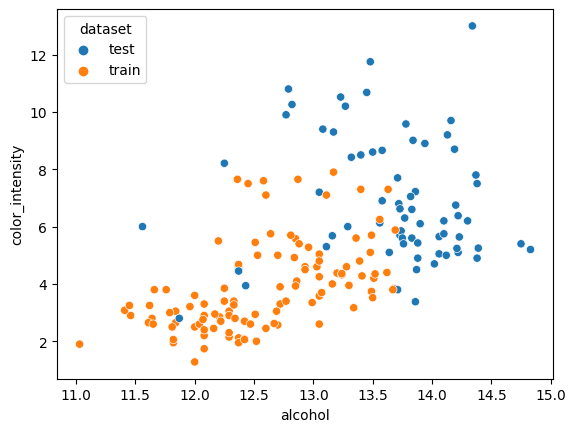

In [11]:
df['dataset'] = 'train'
df.loc[df['alcohol'] >= 13.7, 'dataset'] = 'test'
df.loc[df['color_intensity'] > 8, 'dataset'] = 'test'
df.loc[df['flavanoids'] > 3, 'dataset'] = 'test'

sns.scatterplot(df, x='alcohol', y='color_intensity', hue='dataset');

In [12]:
X_train, y_train = df[df.dataset == 'train'].drop(['target', 'dataset', 'hue'], axis=1), df.loc[df.dataset == 'train', 'target']
X_test, y_test = df[df.dataset == 'test'].drop(['target', 'dataset', 'hue'], axis=1), df.loc[df.dataset == 'test', 'target']

## Training model

In [13]:
model1 = RandomForestClassifier(n_estimators=5, max_depth=4).fit(X_train, y_train)
print(classification_report(model1.predict(X_train), y_train))

print(classification_report(model1.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        64
           2       1.00      1.00      1.00        26

    accuracy                           1.00       109
   macro avg       1.00      1.00      1.00       109
weighted avg       1.00      1.00      1.00       109

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        44
           1       0.71      0.83      0.77         6
           2       0.86      1.00      0.93        19

    accuracy                           0.93        69
   macro avg       0.86      0.91      0.88        69
weighted avg       0.94      0.93      0.93        69



## Adversarial validation

Adversarial Validation is a very clever and very simple way to let us know if our test data and our training data are similar; we combine our train and test data, labeling them with say a 0 for the training data and a 1 for the test data, mix them up, then see if we are able to correctly re-identify them using a binary classifier.

In [14]:
X, y = df.drop(['target', 'dataset', 'hue'], axis=1), df.loc[:, 'dataset']

In [15]:
model2 = RandomForestClassifier(n_estimators=5, max_depth=4).fit(X, y)

print(classification_report(model2.predict(X), y))

              precision    recall  f1-score   support

        test       1.00      0.95      0.97        73
       train       0.96      1.00      0.98       105

    accuracy                           0.98       178
   macro avg       0.98      0.97      0.98       178
weighted avg       0.98      0.98      0.98       178



In [39]:
mapping = {'train': 0, 'test': 1}

In [42]:
print(f'roc_auc_score = {roc_auc_score(list(map(lambda x: mapping[x], model2.predict(X))), list(map(lambda x: mapping[x], y)))}')

roc_auc_score = 0.9726027397260274


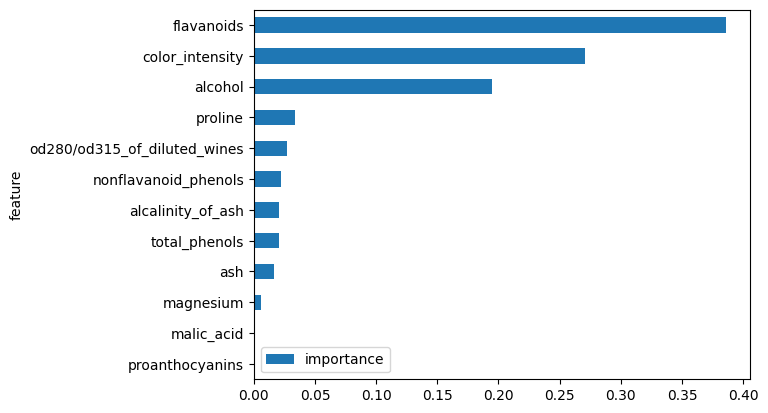

In [16]:
features_df = pd.DataFrame(list(zip(X.columns, model2.feature_importances_)), columns=['feature', 'importance'])
features_df.sort_values('importance', ascending=True).set_index('feature').plot(kind='barh');

### Comparing with proper split

In [21]:
df2 = df.copy()
df2['dataset'] = np.random.choice(['train', 'test'], replace=True, p=[0.7, 0.3], size=df2.shape[0])

X_rand, y_rand = df2.drop(['target', 'dataset', 'hue'], axis=1), df2.loc[:, 'dataset']

model3 = RandomForestClassifier(n_estimators=5, max_depth=4).fit(X_rand, y_rand)

print(classification_report(model3.predict(X_rand), y_rand))

              precision    recall  f1-score   support

        test       0.38      0.83      0.52        24
       train       0.97      0.79      0.87       154

    accuracy                           0.79       178
   macro avg       0.67      0.81      0.69       178
weighted avg       0.89      0.79      0.82       178



In [43]:
print(f'roc_auc_score = {roc_auc_score(list(map(lambda x: mapping[x], model3.predict(X_rand))), list(map(lambda x: mapping[x], y_rand)))}')

roc_auc_score = 0.8095238095238095


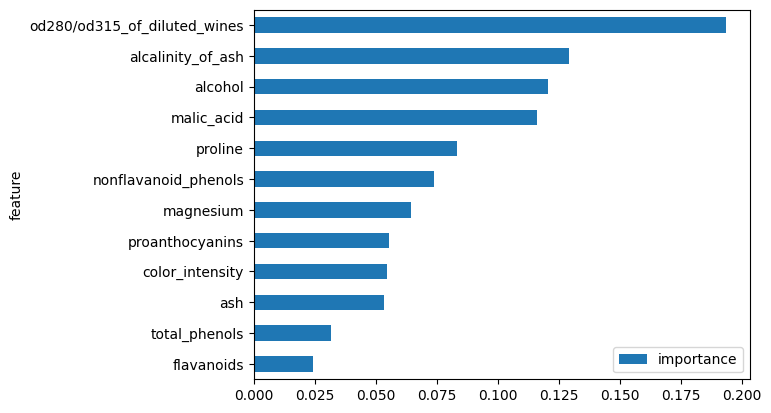

In [22]:
features_df = pd.DataFrame(list(zip(X_rand.columns, model3.feature_importances_)), columns=['feature', 'importance'])
features_df.sort_values('importance', ascending=True).set_index('feature').plot(kind='barh');

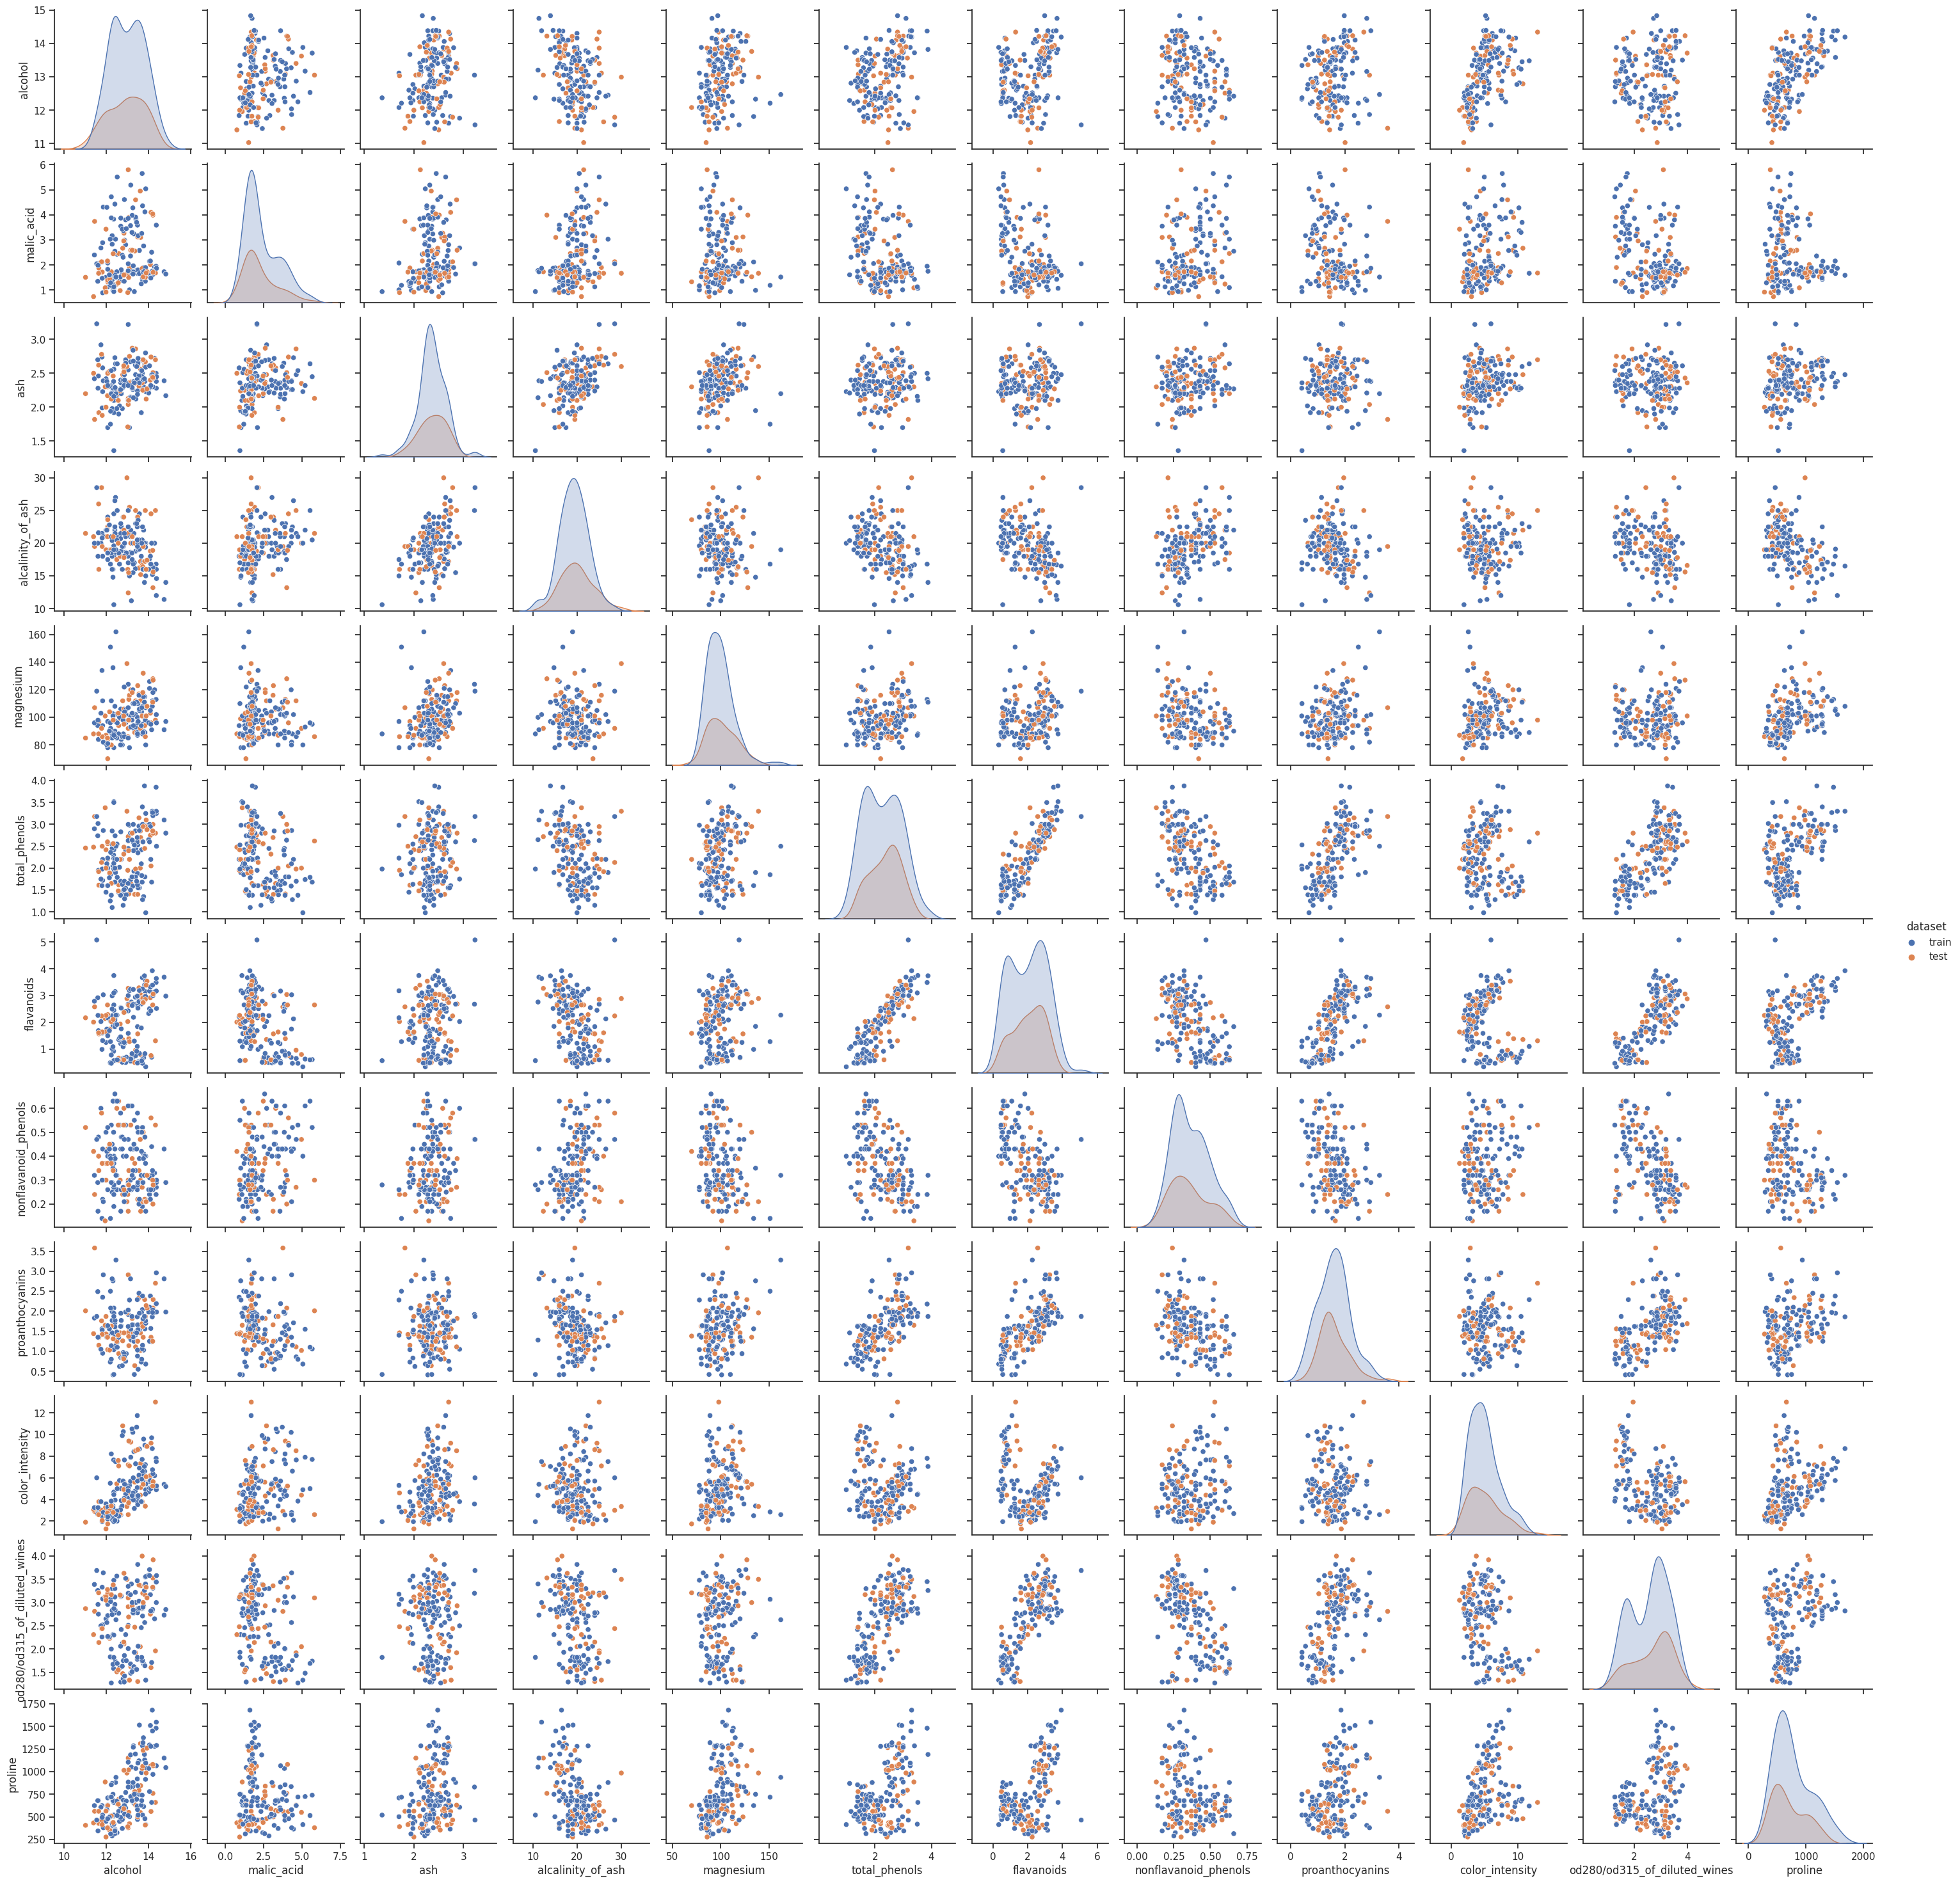

In [45]:
sns.set_theme(style="ticks")
sns.pairplot(df2.drop(['target', 'hue'], axis=1), hue="dataset")